# Harmonic Fits

This notebook showcases the fitting procedures used in the work:  
`Numerical Model Of Harmonic Hall Voltage Detection For Spintronic Devices`

The steps below should produce results displayed in the publication given the version of the CMTJ from January 2022 (later versions may be subject to change).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

OeToAm = 79.57747

# Resistance parameter fits

## Alpha sample 
$$R_{xx} = R_0 + \frac{1}{2}(\Delta R_{XX}^{AMR} + \Delta R_{XX}^{SMR}) + \frac{1}{2}(\Delta R_{XX}^{AMR} - \Delta R_{XX}^{SMR})cos(2\alpha)$$
$$R_{xy} = R_0 + \frac{1}{2}(\Delta R_{XY}^{AMR} + \Delta R_{XY}^{SMR})sin(2\alpha)$$

## Beta sample 

$$R_{xx} = R_0 + \Delta R_{XX}^{SMR}sin^2(\beta)$$
$$R_{xy} = R_0 + \frac{1}{2}\Delta R_{XY}^{AHE}cos(\beta)$$


## Gamma sample 
$$R_{xx} = R_0 + \Delta R_{XX}^{AMR}sin^2(\gamma)$$
$$R_{xy} = R_0 + \frac{1}{2}\Delta R_{XY}^{AHE}cos(\gamma)$$


In [2]:
from scipy.optimize import curve_fit


def fit_beta_rxx(beta_scan, R0, SMR):
    return R0 + SMR * np.power(np.sin(beta_scan), 2)


def fit_beta_rxy(beta_scan, R0, AHE):
    return R0 + 0.5 * AHE * np.cos(beta_scan)


def fit_gamma_rxx(gamma_scan, R0, AMR):
    return R0 + AMR * np.power(np.sin(gamma_scan), 2)


def fit_gamma_rxy(gamma_scan, R0, AHE):
    return R0 + 0.5 * AHE * np.cos(gamma_scan)


def fit_alpha_rxx(alpha_scan, R0, AMR, SMR, offset):
    return R0 + 0.5 * (AMR + SMR) + 0.5 * (AMR - SMR) * np.cos(2 * alpha_scan +
                                                               offset)


def fit_alpha_rxy(alpha_scan, R0, AMR, SMR, offset):
    return R0 + 0.5 * (AMR + SMR) * np.sin(2 * alpha_scan + offset)


rxx = pd.read_csv("Ta_CoFeB/5360_rxx_alpha_beta_gamma.csv", sep=',')
rxy = pd.read_csv("Ta_CoFeB/5360_rxy_alpha_beta_gamma.csv", sep=',')

w = 3e-5
l = 2e-5

### BETA FITS
beta_scan_rxx_deg = rxx['beta'].dropna() - 90
beta_scan_rxy_deg = rxy['beta'].dropna() - 90
beta_scan_rxx = np.deg2rad(rxx['beta'].dropna() - 90)
beta_scan_rxy = np.deg2rad(rxy['beta'].dropna() - 90)

popt, _ = curve_fit(fit_beta_rxx,
                    xdata=beta_scan_rxx,
                    ydata=rxx['rxx_beta'].dropna())
RX0, SMR_XX = popt
beta_rxx = fit_beta_rxx(beta_scan_rxx, RX0, SMR_XX)
popt, _ = curve_fit(fit_beta_rxy,
                    xdata=beta_scan_rxy,
                    ydata=rxy['rxy_beta'].dropna() -
                    rxy['rxy_beta'].dropna().min())
RY0, AHE = popt
RY0 = 1.067
print(f"BETA: {RX0=:.3f}, {SMR_XX=:.3f}, {AHE=:.3f}, {RY0=:.3f}")

beta_rxy = fit_beta_rxy(beta_scan_rxy, RY0, AHE)

### GAMMA FITS
gamma_scan_rxx_deg = rxx['gamma'].dropna() - 90
gamma_scan_rxy_deg = rxy['gamma'].dropna() - 90

gamma_scan_rxx = np.deg2rad(rxx['gamma'].dropna() - 90)
gamma_scan_rxy = np.deg2rad(rxy['gamma'].dropna() - 90)

popt, _ = curve_fit(fit_gamma_rxx,
                    xdata=gamma_scan_rxx,
                    ydata=rxx['rxx_gamma'].dropna())
RX0, AMR_XX = popt
gamma_rxx = fit_gamma_rxx(gamma_scan_rxx, RX0, AMR_XX)
popt, _ = curve_fit(fit_gamma_rxy,
                    xdata=gamma_scan_rxy,
                    ydata=rxy['rxy_gamma'].dropna())
RY0, AHE = popt
print(f"GAMMA: {RX0=:.3f}, {AMR_XX=:.3f}, {AHE=:.3f}, {RY0=:.3f}")
gamma_rxy = fit_gamma_rxy(gamma_scan_rxy, RY0, AHE)

### ALPHA FITS

alpha_scan_rxx_deg = rxx['alpha'].dropna()[2:]
alpha_scan_rxy_deg = rxy['alpha'].dropna()
alpha_scan_rxx = np.deg2rad(rxx['alpha'].dropna())
alpha_scan_rxy = np.deg2rad(rxy['alpha'].dropna())

popt, _ = curve_fit(fit_alpha_rxx,
                    xdata=alpha_scan_rxx,
                    ydata=rxx['rxx_alpha'].dropna(),
                    p0=(RX0, AMR_XX, SMR_XX, 0),
                    bounds=((0, -abs(-AMR_XX * (w / l) * 3),
                             -abs(SMR_XX * (w / l) * 3), -100),
                            (400, abs(-AMR_XX * (w / l) * 3),
                             abs(SMR_XX * (w / l) * 3), 100)))
RX0, AMR_XX, SMR_XX, offset1 = popt

popt, _ = curve_fit(fit_alpha_rxy,
                    xdata=alpha_scan_rxy,
                    ydata=rxy['rxy_alpha'].dropna(),
                    bounds=((0, -abs(-AMR_XX * (w / l) * 3),
                             -abs(SMR_XX * (w / l) * 3), -100),
                            (400, abs(-AMR_XX * (w / l) * 3),
                             abs(SMR_XX * (w / l) * 3), 100)),
                    p0=(0, -AMR_XX * (w / l), SMR_XX * (w / l), 0))
RY0, AMR_XY, SMR_XY, offset2 = popt
offsetdeg = np.rad2deg(offset2)
print(
    f"ALPHA: {RX0=:.3f}, {RY0=:.3f}, {AMR_XX=:.3f}, {SMR_XX=:.3f}, {AMR_XY=:.3f}, {SMR_XY=:.3f}, {offsetdeg=:.3f}"
)

AMR_XY = AMR_XX * -(w / l)
SMR_XY = SMR_XX * (w / l)

alpha_rxx = fit_alpha_rxx(alpha_scan_rxx, RX0, AMR_XX, SMR_XX, offset1)
alpha_rxy = fit_alpha_rxy(alpha_scan_rxy, RY0, AMR_XY, SMR_XY, offset2)
print(f"{AMR_XY=:.3f}, {SMR_XY=:.3f}")
print(f"{AMR_XX*(-w/l)=:.3f}, {SMR_XX*(w/l)=:.3f}")

BETA: RX0=304.770, SMR_XX=-0.466, AHE=5.747, RY0=1.067
GAMMA: RX0=304.788, AMR_XX=-0.053, AHE=5.711, RY0=1.067
ALPHA: RX0=305.561, RY0=1.008, AMR_XX=-0.053, SMR_XX=-0.463, AMR_XY=0.091, SMR_XY=-0.486, offsetdeg=-13.728
AMR_XY=0.079, SMR_XY=-0.695
AMR_XX*(-w/l)=0.079, SMR_XX*(w/l)=-0.695


The `Rxy` parameter is not considered crucial. For the `AHE` we pick 5.71. The fits for the ALPHA have fixed values from earlier as there's some fluctuation in the measurement.

The following parameters will be used for further fittings:
```
Rx0 = [304.306]
Ry0 = [1.008] or [3] # this is only the offset
SMR = [-0.464]
AMR = [-0.053]
AHE = [-5.71]
w = [3e-5]
l = [2e-5]
```

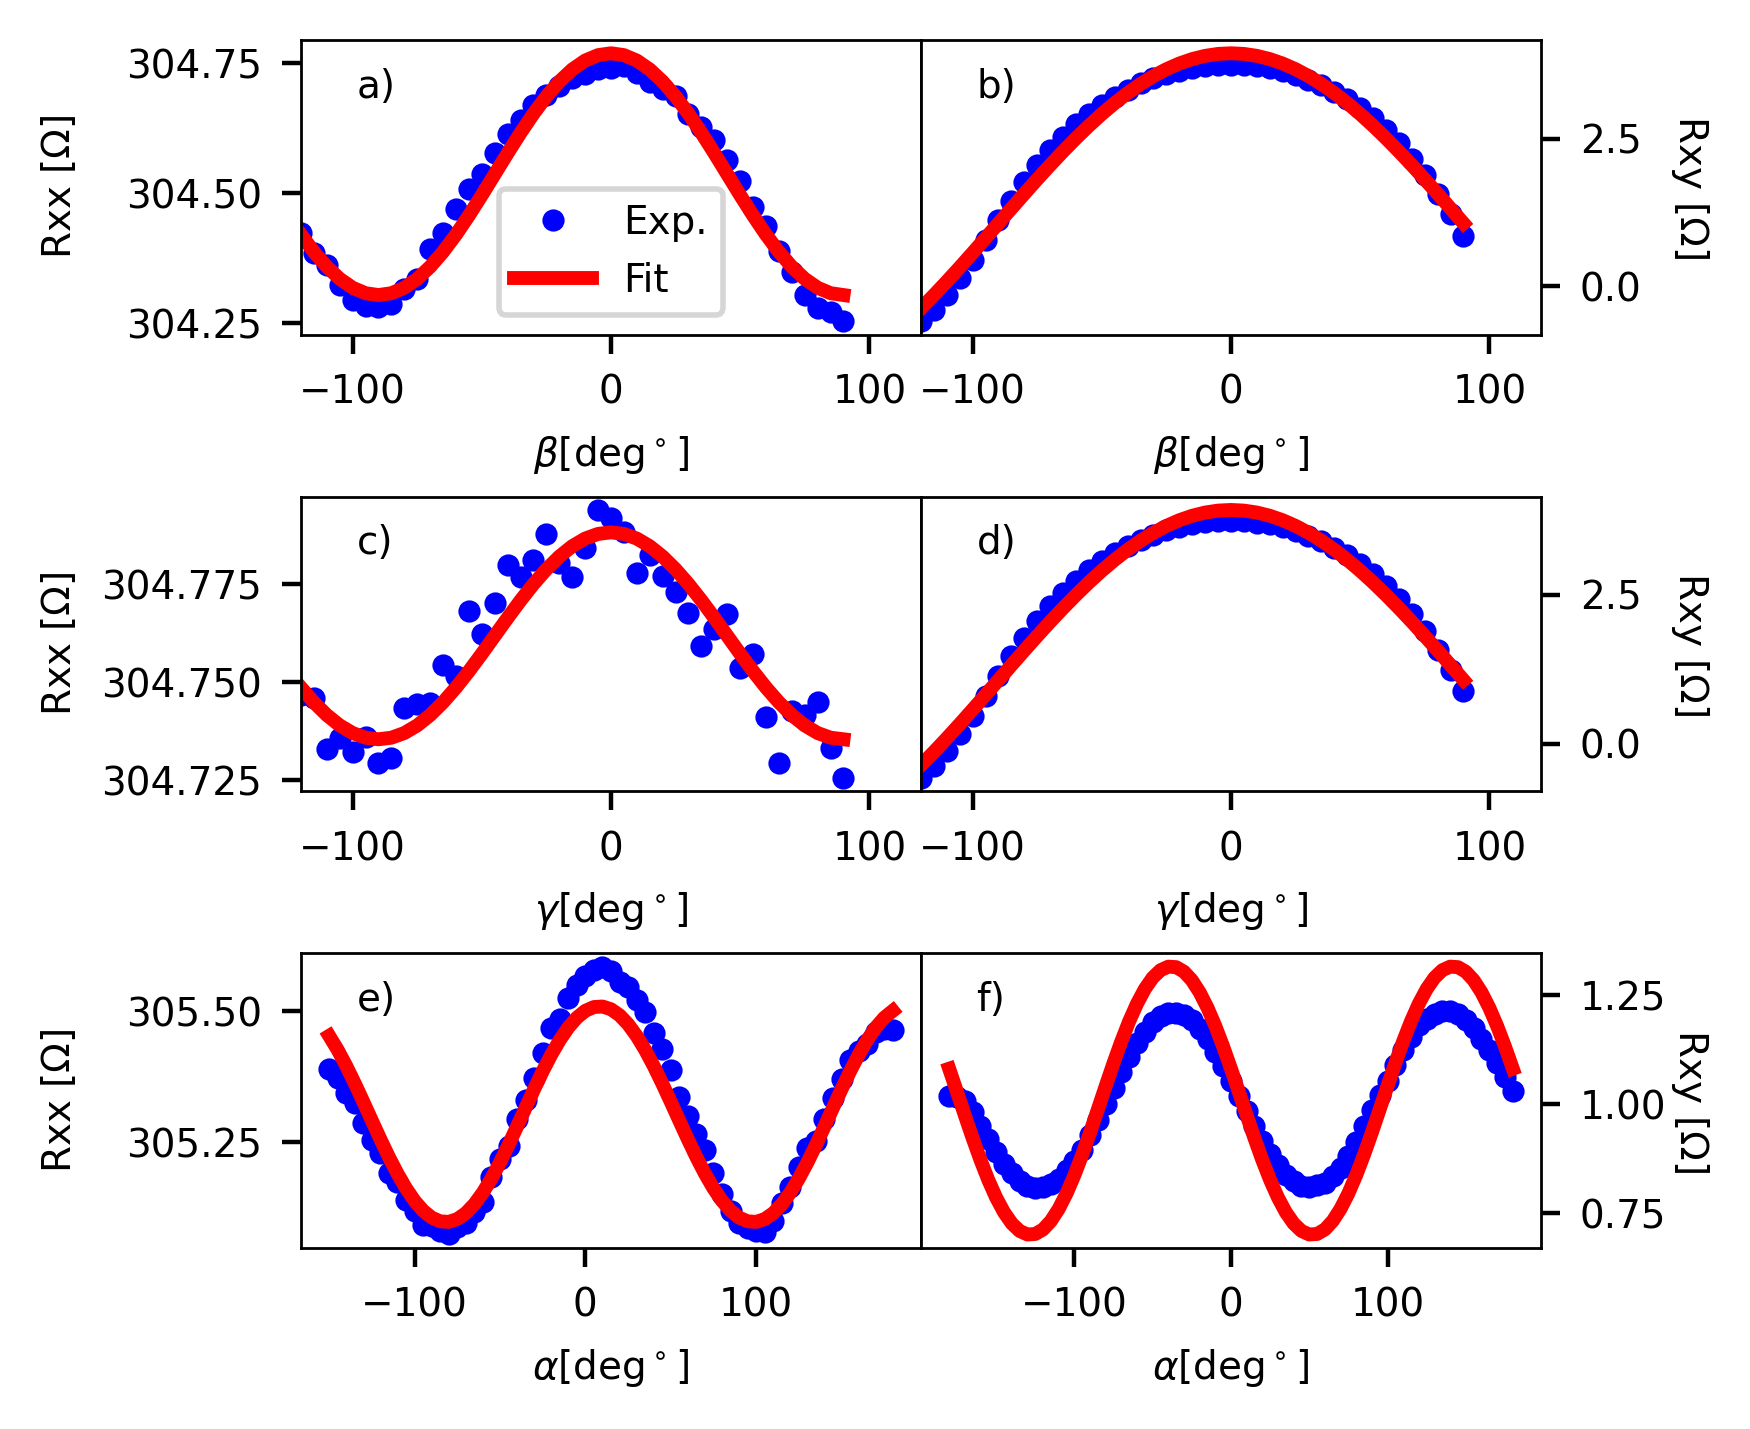

In [3]:
import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False

lw = 2.5
with plt.style.context(['nature']):
    fig, ax = plt.subplots(3, 2, figsize=(4, 4), dpi=400)
    ax[0, 0].plot(beta_scan_rxx_deg,
                  rxx['rxx_beta'].dropna(),
                  'bo',
                  label='Exp.')
    ax[0, 0].plot(beta_scan_rxx_deg, beta_rxx, 'r-', label='Fit', linewidth=lw)
    ax[0, 0].set_xlabel(r"$\beta [\mathrm{deg}^\circ]$")
    ax[0, 0].set_ylabel(r"Rxx $[\Omega]$")

    ax[0, 1].plot(beta_scan_rxy_deg, rxy['rxy_beta'].dropna(), 'bo')
    ax[0, 1].plot(beta_scan_rxy_deg, beta_rxy, 'r-', linewidth=lw)
    ax[0, 1].set_xlabel(r"$\beta [\mathrm{deg}^\circ]$")
    ax[0, 1].set_ylabel(r"Rxy $[\Omega]$", rotation=270, labelpad=8)

    spac = 120
    ax[0, 1].set_xlim([-spac, spac])
    ax[0, 0].set_xlim([-spac, spac])

    ax[1, 0].plot(gamma_scan_rxx_deg, rxx['rxx_gamma'].dropna(), 'bo')
    ax[1, 0].plot(gamma_scan_rxx_deg, gamma_rxx, 'r-', linewidth=lw)
    ax[1, 0].set_xlabel(r"$\gamma [\mathrm{deg}^\circ]$")
    ax[1, 0].set_ylabel(r"Rxx $[\Omega]$")

    ax[1, 1].plot(gamma_scan_rxy_deg, rxy['rxy_gamma'].dropna(), 'bo')
    ax[1, 1].plot(gamma_scan_rxy_deg, gamma_rxy, 'r-', linewidth=lw)
    ax[1, 1].set_xlabel(r"$\gamma [\mathrm{deg}^\circ]$")
    ax[1, 1].set_ylabel(r"Rxy $[\Omega]$", rotation=270, labelpad=8)

    ax[1, 1].set_xlim([-spac, spac])
    ax[1, 0].set_xlim([-spac, spac])

    ax[2, 0].plot(alpha_scan_rxx_deg, rxx['rxx_alpha'].dropna()[2:], 'bo')
    ax[2, 0].plot(alpha_scan_rxx_deg, alpha_rxx[2:], 'r-', linewidth=lw)
    ax[2, 0].set_xlabel(r"$\alpha [\mathrm{deg}^\circ]$")
    ax[2, 0].set_ylabel(r"Rxx $[\Omega]$")

    ax[2, 1].plot(alpha_scan_rxy_deg, rxy['rxy_alpha'].dropna(), 'bo')
    ax[2, 1].plot(alpha_scan_rxy_deg, alpha_rxy, 'r-', linewidth=lw)
    ax[2, 1].set_xlabel(r"$\alpha [\mathrm{deg}^\circ]$")
    ax[2, 1].set_ylabel(r"Rxy $[\Omega]$", rotation=270, labelpad=8)
    ax[0, 0].legend(loc=8)

    for i in range(3):
        ax[i, 1].yaxis.tick_right()
        ax[i, 1].yaxis.set_label_position("right")

    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)', 'c)', 'd)', 'e)', 'f)'], ax.flatten()):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

    fig.subplots_adjust(wspace=0., hspace=0.55)
    fig.align_ylabels()

# Layer parameter fits

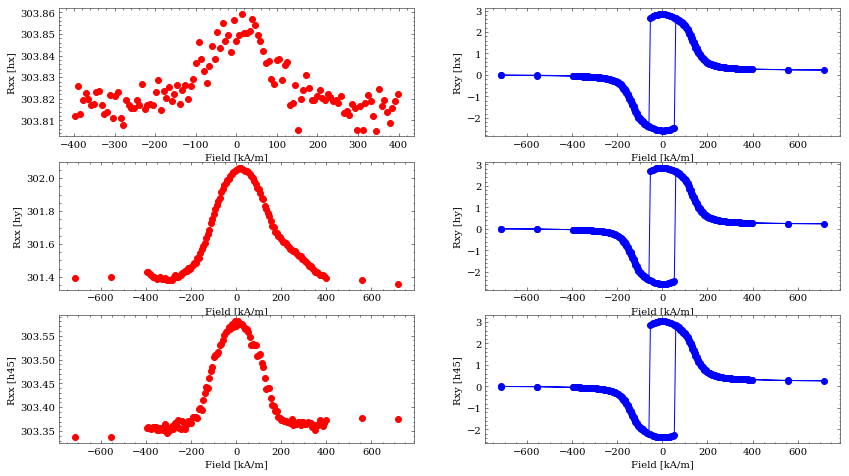

In [4]:
rxx = pd.read_csv('Ta_CoFeB/5360_rxx_hx_h45_hy.csv', sep=',')
rxy = pd.read_csv('Ta_CoFeB/5360_rxy_hx_h45_hy.csv', sep=',')

with plt.style.context(['science', 'no-latex']):
    fig, ax = plt.subplots(3, 2, figsize=(14, 8))
    orientations = ['hx', 'hy', 'h45']
    for i, orient in enumerate(orientations):
        field_x = rxx[f'{orient}'] * OeToAm / 1e3  # to kA/m
        res_x = rxx[f"rxx_{orient}"]
        field_y = rxy[f'{orient}'] * OeToAm / 1e3  # to kA/m
        res_y = rxy[f"rxy_{orient}"] - rxy[f"rxy_{orient}"][0]
        ax[i, 0].plot(field_x, res_x, 'ro')
        ax[i, 1].plot(field_y, res_y, 'bo-')
        ax[i, 0].set_xlabel("Field [kA/m]")
        ax[i, 0].set_ylabel(f"Rxx [{orient}]")
        ax[i, 1].set_xlabel("Field [kA/m]")
        ax[i, 1].set_ylabel(f"Rxy [{orient}]")

# Resistance measurement in non-saturating field

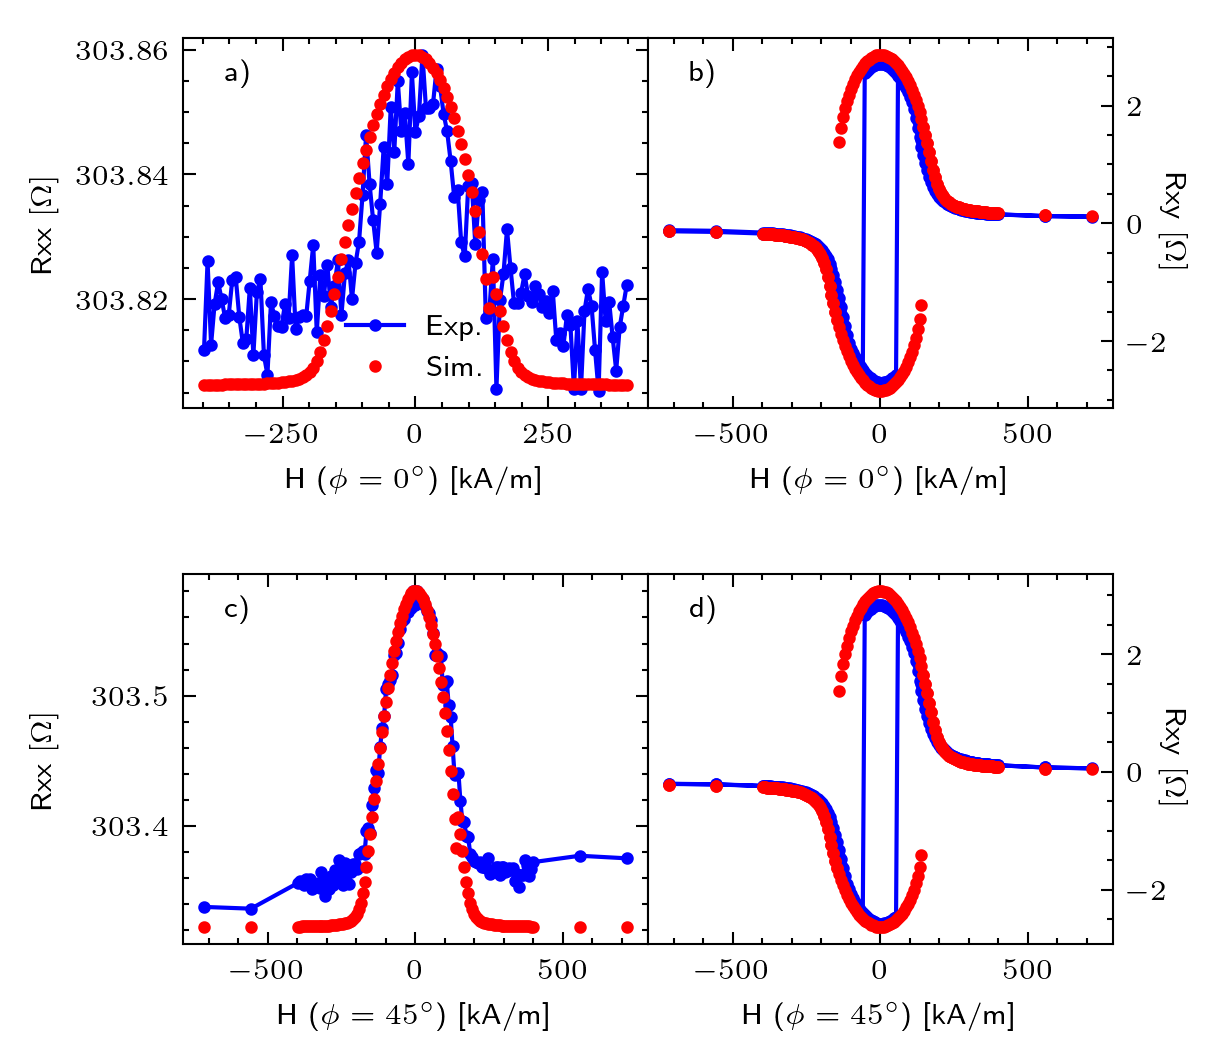

In [5]:
### generate data for publication
from collections import defaultdict
from cmtj import CVector, Layer, Junction, ScalarDriver, AxialDriver, NullDriver
from cmtj.utils.linear import FieldScan
from tqdm import tqdm
import numpy as np

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
fsize = 20
lw = 5

Rx0 = [304.306]
Ry0 = [1.008]
SMR = [-0.464]
AMR = [-0.053]
AHE = [-5.71]
w = [3e-5]
l = [2e-5]


def get_field_scan_from_angle(experiment_field, theta, phi):
    st, ct, sp, cp = FieldScan._trig_compute(theta, phi)
    Hx = st * cp * experiment_field
    Hy = st * sp * experiment_field
    Hz = ct * experiment_field

    Hvecs = np.vstack((Hx, Hy, Hz)).T
    return Hvecs


def calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m, number_of_layers, l, w):
    if m.ndim == 2:
        SxAll = np.zeros((number_of_layers, ))
        SyAll = np.zeros((number_of_layers, ))

    elif m.ndim == 3:
        SxAll = np.zeros((number_of_layers, m.shape[2]))
        SyAll = np.zeros((number_of_layers, m.shape[2]))

    for i in range(0, number_of_layers):
        w_l = w[i] / l[i]
        SxAll[i] = 1 / (Rx0[i] + (AMR[i] * m[i, 0]**2 + SMR[i] * m[i, 1]**2))
        SyAll[i] = 1 / (Ry0[i] + 0.5 * AHE[i] * m[i, 2] + (w_l) *
                        (SMR[i] - AMR[i]) * m[i, 0] * m[i, 1])

    Rx = 1 / np.sum(SxAll, axis=0)
    Ry = 1 / np.sum(SyAll, axis=0)
    return Rx, Ry


def run_simulation(junction: Junction, Hvecs: np.ndarray, mode: str):
    sim_time = 10e-9
    int_time = 4e-12
    layer_str = ['free']
    mags = [CVector(0, 0, 1) for _ in layer_str]
    Rxy, Rxx = [], []
    for Hval in Hvecs:
        junction.clearLog()
        HDriver = AxialDriver(ScalarDriver.getConstantDriver(Hval[0]),
                              ScalarDriver.getConstantDriver(Hval[1]),
                              ScalarDriver.getConstantDriver(Hval[2]))
        junction.setLayerExternalFieldDriver("all", HDriver)
        # set mags for better convergence
        for i, l_str in enumerate(layer_str):
            junction.setLayerMagnetisation(l_str, mags[i])

        junction.runSimulation(sim_time, int_time, int_time)

        # set new mags
        for str_ in layer_str:
            mags[i] = junction.getLayerMagnetisation(str_)

        log = junction.getLog()
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]
             for str_ in layer_str])
        dynamicRx, dynamicRy = calculate_resistance(Rx0, [0],
                                                    AMR=AMR,
                                                    AHE=AHE,
                                                    SMR=SMR,
                                                    m=m,
                                                    number_of_layers=1,
                                                    l=l,
                                                    w=w)

        Rxy.append(dynamicRy[-1])
        Rxx.append(dynamicRx[-1])
    if mode.lower() == 'rxx':
        return np.asarray(Rxx)
    else:
        return np.asarray(Rxy)


def simulate(Ku, Ms, Hvecs, alpha, mode='rxx'):
    demagTensor = [
        CVector(0.00024164288391924, 2.71396011566517e-10,
                5.95503928124313e-14),
        CVector(2.71396011566517e-10, 0.000160046006320031,
                1.32504057070646e-14),
        CVector(5.95503928124313e-14, 1.32504057070646e-14, 0.999598310229469)
    ]

    thickness = 1.45e-9
    l1 = Layer(
        id="free",
        mag=CVector(0, 0, 1),
        anis=CVector(0, 0., 1),
        Ms=Ms,
        thickness=thickness,
        cellSurface=0,  # does not matter
        damping=alpha,
        demagTensor=demagTensor,
    )
    junction = Junction([l1])

    HoePulseAmpl = 50
    HoeDriver = AxialDriver(
        NullDriver(), NullDriver(),
        ScalarDriver.getStepDriver(0, HoePulseAmpl, 0.0, 1e-11))
    junction.setLayerOerstedFieldDriver("all", HoeDriver)
    junction.setLayerAnisotropyDriver("all",
                                      ScalarDriver.getConstantDriver(Ku))

    return run_simulation(junction=junction, Hvecs=Hvecs, mode=mode)


ms = 2
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=300)
    resistance_data = defaultdict(list)
    for i, field in enumerate(('hx', 'h45')):
        for j, (res_mode, res_mode_data) in enumerate(
            (('rxx', rxx), ('rxy', rxy))):
            opt_scan = (res_mode_data[f'{field}'] * OeToAm).dropna()
            exp_y = res_mode_data[f'{res_mode}_{field}'].dropna()
            try:
                assert opt_scan.shape[0] == exp_y.shape[0]
            except:
                print(opt_scan.shape, exp_y.shape)
                print(res_mode, field)
                continue
            flabel = field.capitalize()
            if field == 'hx':
                phi = 1
                flabel = r"H ($\phi=0^\circ$)"
            elif field == 'hy':
                phi = 90
                flabel = r"H ($\phi=90^\circ$)"
            elif field == 'h45':
                phi = 45
                flabel = r"H ($\phi=45^\circ$)"
            else:
                raise ValueError("Unknown field orientation")

            theta = 92
            opt_vecs = get_field_scan_from_angle(opt_scan,
                                                 theta=theta,
                                                 phi=phi)
            if res_mode == "rxx":
                Rx0 = [exp_y.max()]
            simulated = simulate(Ms=0.525,
                                 Ku=1.54e5,
                                 alpha=0.03,
                                 mode=res_mode,
                                 Hvecs=opt_vecs)
            if res_mode == 'rxy':
                exp_y -= np.mean(exp_y)
                simulated -= np.mean(simulated)
                
            resistance_data[f'{res_mode}_{field}'] = (opt_scan / 1e3).tolist()
            resistance_data[f'sim_{field}_{res_mode}'] = (simulated).tolist()
            ax[i, j].plot(resistance_data[f'{res_mode}_{field}'],
                          exp_y,
                          'bo-',
                          markersize=ms,
                          label='Exp.')
            ax[i, j].plot(resistance_data[f'{res_mode}_{field}'],
                          simulated,
                          'ro',
                          markersize=ms,
                          label='Sim.')
            ax[i, j].set_xlabel(f"{flabel} [kA/m]")
            ax[i, j].set_ylabel(f"{res_mode.capitalize()} $[\Omega]$")
            ax[i, 1].yaxis.tick_right()
        ax[i, 1].yaxis.set_label_position("right")
        ax[i, 1].set_ylabel(f"{res_mode.capitalize()} $[\Omega]$",
                            rotation=270)
    ax[0, 0].legend(loc=8)

    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)', 'c)', 'd)', 'e)', 'f)'], ax.flatten()):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

    fig.align_ylabels()
    fig.subplots_adjust(wspace=0., hspace=0.45)

# The influence of the $\theta$ angle on the width

In [6]:
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal.windows import hann

Rx0 = [304.306]
Ry0 = [3]
SMR = [-0.464]
AMR = [-0.053]
AHE = [-5.71]
w = [3e-5]
l = [2e-5]


def compute_vsd(dynamicR, integration_step, dynamicI):
    SD = dynamicI * dynamicR
    # SD -= np.mean(SD)
    # SD *= hann(len(SD))
    y = fft(SD) * (2 / len(SD))
    amp = np.abs(y)
    phase = np.angle(y)
    freqs = fftfreq(len(y), integration_step)
    y = y[:len(y) // 2]
    freqs = freqs[:len(freqs) // 2]
    return amp, phase, freqs


def calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m, number_of_layers, l, w):
    if m.ndim == 2:
        SxAll = np.zeros((number_of_layers, ))
        SyAll = np.zeros((number_of_layers, ))

    elif m.ndim == 3:
        SxAll = np.zeros((number_of_layers, m.shape[2]))
        SyAll = np.zeros((number_of_layers, m.shape[2]))

    for i in range(0, number_of_layers):
        w_l = w[i] / l[i]
        SxAll[i] = 1 / (Rx0[i] + (AMR[i] * m[i, 0]**2 + SMR[i] * m[i, 1]**2))
        SyAll[i] = 1 / (Ry0[i] + 0.5 * AHE[i] * m[i, 2] + (w_l) *
                        (SMR[i] - AMR[i]) * m[i, 0] * m[i, 1])

    Rx = 1 / np.sum(SxAll, axis=0)
    Ry = 1 / np.sum(SyAll, axis=0)
    return Rx, Ry


def find_max_f_frequency(freqs: np.ndarray, values: np.ndarray,
                         frequency: float):
    # take between 0 and max
    freq_indx = np.abs(freqs - frequency).argmin()
    max_value = values[freq_indx]
    max_freq = freqs[freq_indx]
    return max_value, max_freq


def compute_harmonics(mode, theta, Ms, Ku, Hdl, Hfl, back=True):
    if mode == 'hx':
        phi = 1
    elif mode == 'hy':
        phi = 87
    else:
        raise ValueError("Unknown mode")

    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1.)
    ]

    thickness = 1.45e-9
    I_rf = 2.68e-3

    s_time = 100e-9
    int_step = 1e-11

    l1_params = {
        "Ms": Ms,
        "thickness": thickness,
        "anis": CVector(0., 0., 1.),
        "mag": CVector(0, 0, 1.),
        "cellSurface": 1.0,
        "demagTensor": demagTensor,
        "damping": 0.003,
    }
    l1 = Layer(id="free", **l1_params)
    l1.setReferenceLayer(CVector(0., 1., 0.))
    layer_str = ["free"]
    layers = [l1]
    junction = Junction(layers=layers)
    junction.setLayerAnisotropyDriver("all",
                                      ScalarDriver.getConstantDriver(Ku))

    frequency = .8e9

    his = 100
    Hscan, Hvecs = FieldScan.amplitude_scan(-400e3,
                                            400e3,
                                            his,
                                            theta,
                                            phi,
                                            back=back)
    amp_diag1f = np.zeros((len(Hscan), ))
    phase_diag2f = np.zeros((len(Hscan), ))
    junction.setLayerDampingLikeTorqueDriver(
        "all", ScalarDriver.getSineDriver(0, Hdl, frequency, 0))
    junction.setLayerFieldLikeTorqueDriver(
        "all", ScalarDriver.getSineDriver(0, Hfl, frequency, 0))
    mags = [CVector(0, 0, 1) for _ in layer_str]
    for hi, Hval in enumerate(Hvecs):
        junction.clearLog()
        HDriver = AxialDriver(ScalarDriver.getConstantDriver(Hval[0]),
                              ScalarDriver.getConstantDriver(Hval[1]),
                              ScalarDriver.getConstantDriver(Hval[2]))
        junction.setLayerExternalFieldDriver("all", HDriver)
        # set mags for better convergence
        for i, l_str in enumerate(layer_str):
            junction.setLayerMagnetisation(l_str, mags[i])

        junction.runSimulation(s_time, int_step, int_step)
        # set new mags
        for str_ in layer_str:
            mags[i] = junction.getLayerMagnetisation(str_)

        log = junction.getLog()
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]
             for str_ in layer_str])

        dynamicRx, dynamicRy = calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m,
                                                    len(layer_str), l, w)

        lt = np.asarray(log['time'])
        dynamicI = I_rf * np.sin(2 * np.pi * frequency * lt)
        org_amp, org_phase, freqs_org = compute_vsd(dynamicR=dynamicRy,
                                                    integration_step=int_step,
                                                    dynamicI=dynamicI)

        max_phase2f, max_freq = find_max_f_frequency(freqs_org, org_phase,
                                                     2 * frequency)
        max_amp1f, _ = find_max_f_frequency(freqs_org, org_amp, frequency)
        max_amp2f, _ = find_max_f_frequency(freqs_org, org_amp, 2 * frequency)
        amp_diag1f[hi] = max_amp1f
        phase_diag2f[hi] = np.cos(max_phase2f) * max_amp2f
    return amp_diag1f, phase_diag2f, Hscan


Ms = 0.525
Ku = 1.54e5
Hdl = -420
Hfl = 574
theta_hx = 90.2
theta_hy = 90.2

amp_diag1f_Hx, phase_diag2f_Hx, Hscan_Hx = compute_harmonics('hx',
                                                             theta=theta_hx,
                                                             Ms=Ms,
                                                             Ku=Ku,
                                                             Hdl=Hdl,
                                                             Hfl=Hfl)
amp_diag1f_Hy, phase_diag2f_Hy, Hscan_Hy = compute_harmonics('hy',
                                                             theta=theta_hy,
                                                             Ms=Ms,
                                                             Ku=Ku,
                                                             Hdl=Hdl,
                                                             Hfl=Hfl)

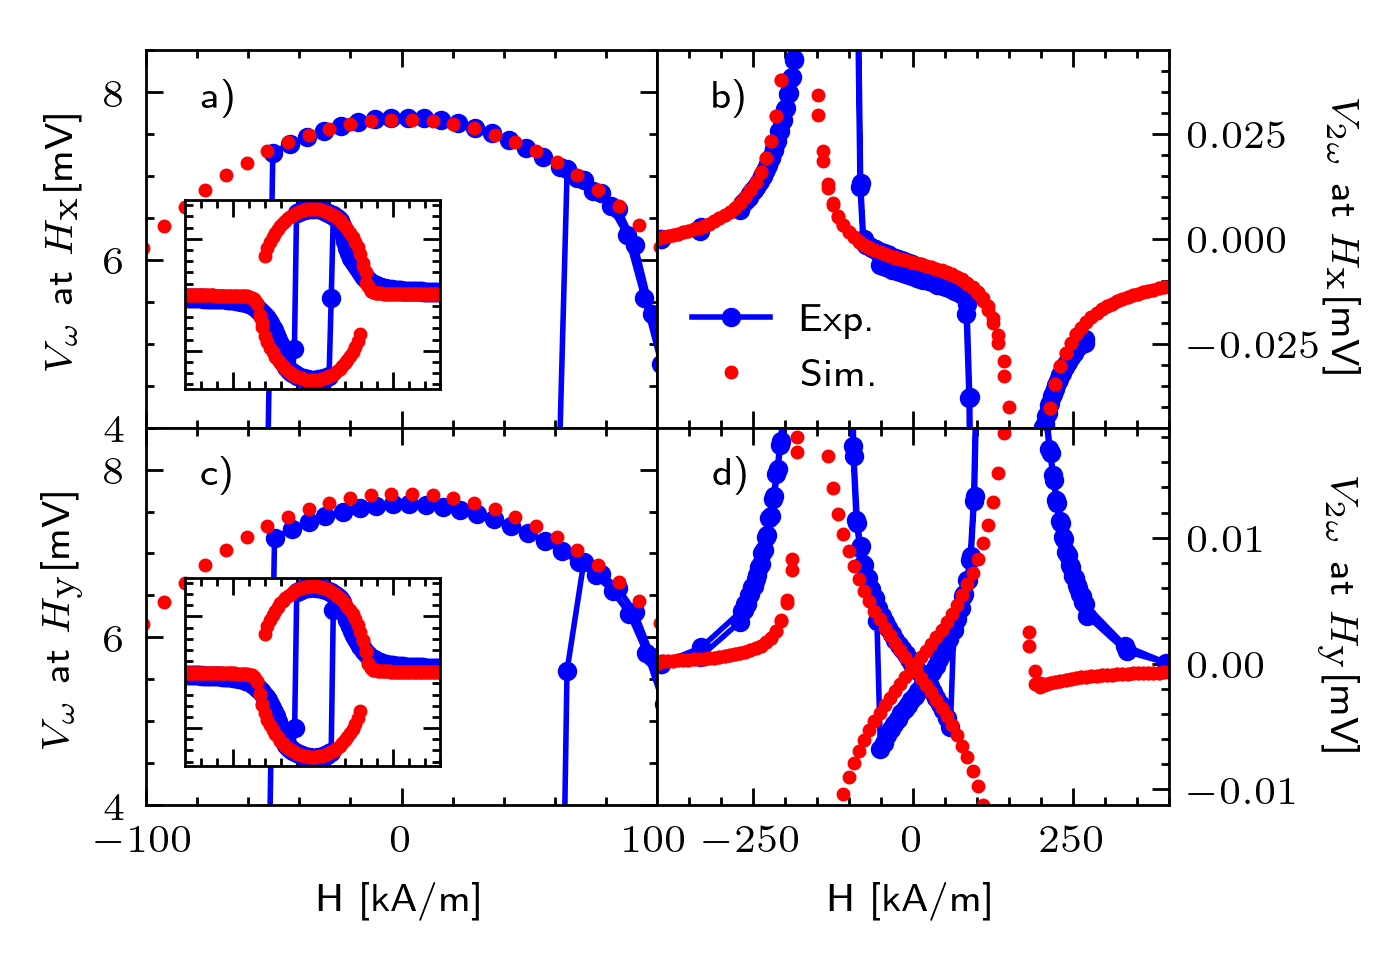

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

amp_diag1f_Hy -= amp_diag1f_Hy.mean()
amp_diag1f_Hx -= amp_diag1f_Hx.mean()
phase_diag2f_Hy -= phase_diag2f_Hy[0]
phase_diag2f_Hx -= phase_diag2f_Hx[0]

dat = {
    'Hx': Hscan_Hx,
    'Hy': Hscan_Hy,
    'Hx1f': amp_diag1f_Hx,
    'Hx2f': phase_diag2f_Hx,
    'Hy1f': amp_diag1f_Hy,
    'Hy2f': phase_diag2f_Hy
}
har1f = pd.read_csv("Ta_CoFeB/5360_1f_hx_hy.csv", sep=',')
har2f = pd.read_csv("Ta_CoFeB/5360_2f_hx_hy.csv", sep=',')

ms = 2.5
sim_ms = 1.5
scale = 1e3
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(
        2,
        2,
        sharex='col',
        dpi=400,
    )
    for i, ho in enumerate(('hx', 'hy')):
        mode = ho.capitalize()
        har1f_H = (har1f[f'{mode}'] * OeToAm).dropna() / 1e3
        har1f_a = har1f[f'{mode}_1f_voltage'].dropna()
        har1f_a -= har1f_a.mean()

        har2f_H = (har2f[f'{mode}'] * OeToAm).dropna() / 1e3
        har2f_a = har2f[f'{mode}_2f_voltage'].dropna()
        har2f_a -= har2f_a[0]

        ax[i, 0].plot(har1f_H,
                      har1f_a * scale,
                      "bo-",
                      markersize=ms,
                      label='Exp.')
        ax[i, 0].plot(dat[mode] / 1e3,
                      dat[f"{mode}1f"] * scale,
                      "ro",
                      alpha=1,
                      markersize=sim_ms,
                      label='Sim.')

        axins = inset_axes(ax[i, 0],
                           width="50%",
                           height="50%",
                           loc=3,
                           borderpad=1)
        axins.tick_params(labelleft=False, labelbottom=False)
        axins.set_xlim([-400, 400])
        axins.plot(har1f_H,
                   har1f_a * scale,
                   "bo-",
                   markersize=ms,
                   label='Exp.')
        axins.plot(dat[mode] / 1e3,
                   dat[f"{mode}1f"] * scale,
                   "ro",
                   alpha=1,
                   markersize=sim_ms,
                   label='Sim.')
        ax[i, 0].set_ylim([4, 8.5])
        ax[i, 0].set_xlim([-100, 100])

        ax[i, 1].plot(har2f_H,
                      har2f_a * scale,
                      "bo-",
                      markersize=ms,
                      label='Exp.')
        ax[i, 1].plot(dat[mode] / 1e3,
                      dat[f"{mode}2f"] * scale,
                      "ro",
                      alpha=1,
                      markersize=sim_ms,
                      label='Sim.')

        ax[i, 1].set_xlim([-400, 400])
        if ho == 'hx':
            ax[i, 1].set_ylim([-4.5e-4 * scale / 10, 4.5e-4 * scale / 10])
        else:
            ax[i, 1].set_ylim([-4.5e-5 * scale / 4, 7.5e-5 * scale / 4])
        lw = 1.5
    ax[1, 0].set_xlabel(f"H [kA/m]")
    ax[1, 1].set_xlabel(f"H [kA/m]")

    ax[0, 0].set_ylabel(r"$V_{\omega}$ at $H_\textrm{x}$[mV]")
    ax[1, 0].set_ylabel(r"$V_{\omega}$ at $H_\textrm{y}$[mV]")

    ax[0, 1].set_ylabel(r"$V_{2\omega}$ at $H_\textrm{x}$[mV]",
                        rotation=270,
                        labelpad=6.5)
    ax[1, 1].set_ylabel(r"$V_{2\omega}$ at $H_\textrm{y}$[mV]",
                        rotation=270,
                        labelpad=6.5)

    ax[0, 1].yaxis.tick_right()
    ax[1, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position("right")
    ax[1, 1].yaxis.set_label_position("right")
    fig.align_ylabels(ax)
    fig.subplots_adjust(wspace=0, hspace=0.)
    ax[0, 1].legend(loc=3)

    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)', 'c)', 'd)'], ax.flatten()):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))


# Colors Harmonics

In [8]:
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal.windows import hann

Rx0 = [304.306]
Ry0 = [3]
SMR = [-0.464]
AMR = [-0.053]
AHE = [-5.71]
w = [3e-5]
l = [2e-5]

N = 20
eps = 0.05
Ms = 0.525
Ku = 1.54e5
theta = 92

Hdl = -420
Hfl = 574

theta_space = np.linspace(90.1, 90.1 * (1 + eps) / (1 - eps),
                          N)  # we need to avoid changing sign
Ms_space = np.linspace((1 - eps) * Ms, (1 + eps) * Ms, N)
Ku_space = np.linspace((1 - eps) * Ku, (1 + eps) * Ku, N)
scans = zip(['theta', 'Ms', 'Ku'], [theta_space, Ms_space, Ku_space])
# scans = zip(['Hdl', 'Hfl', 'Ms', 'Ku'],
#             [Hdl_space, Hfl_space, Ms_space, Ku_space])
ensemble_data = defaultdict(list)
for MODE in ('Hx', 'Hy'):
    mode = MODE.lower()
    for n, v in zip(['theta', 'Ms', 'Ku'], [theta_space, Ms_space, Ku_space]):
        for v_ in tqdm(v, desc=f'Computing: {n} for {MODE}'):
            if n == 'theta':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(mode,
                                                                    theta=v_,
                                                                    Ms=Ms,
                                                                    Ku=Ku,
                                                                    Hdl=Hdl,
                                                                    Hfl=Hfl)
            elif n == 'Ms':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(
                    mode, theta=theta, Ms=v_, Ku=Ku, Hdl=Hdl, Hfl=Hfl)
            elif n == 'Ku':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(
                    mode, theta=theta, Ms=Ms, Ku=v_, Hdl=Hdl, Hfl=Hfl)
            elif n == 'Hdl':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(
                    mode, theta=theta, Ms=Ms, Ku=Ku, Hdl=v_, Hfl=Hfl)
            elif n == 'Hfl':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(
                    mode, theta=theta, Ms=Ms, Ku=Ku, Hdl=Hdl, Hfl=v_)
            else:
                raise ValueError("Unknown parameter")
            amp_diag1f -= amp_diag1f.mean()
            phase_diag2f -= phase_diag2f[0]
            ensemble_data[f"{n}_1f_{mode}"].append(amp_diag1f)
            ensemble_data[f"{n}_2f_{mode}"].append(phase_diag2f)
            ensemble_data[f"{n}_field_{mode}"].append(Hscan / 1e3)

Computing: Ku for Hy: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


In [9]:
Hdl = -420
Hfl = 574
Ms = 0.525
Ku = 1.54e5
theta = 92
amp_diag1f_Hx, phase_diag2f_Hx, Hscan_Hx = compute_harmonics('hx',
                                                             theta=theta,
                                                             Ms=Ms,
                                                             Ku=Ku,
                                                             Hdl=Hdl,
                                                             Hfl=Hfl)
amp_diag1f_Hy, phase_diag2f_Hy, Hscan_Hy = compute_harmonics('hy',
                                                             theta=theta,
                                                             Ms=Ms,
                                                             Ku=Ku,
                                                             Hdl=Hdl,
                                                             Hfl=Hfl)

amp_diag1f_Hy -= amp_diag1f_Hy.mean()
amp_diag1f_Hx -= amp_diag1f_Hx.mean()
phase_diag2f_Hy -= phase_diag2f_Hy[0]
phase_diag2f_Hx -= phase_diag2f_Hx[0]

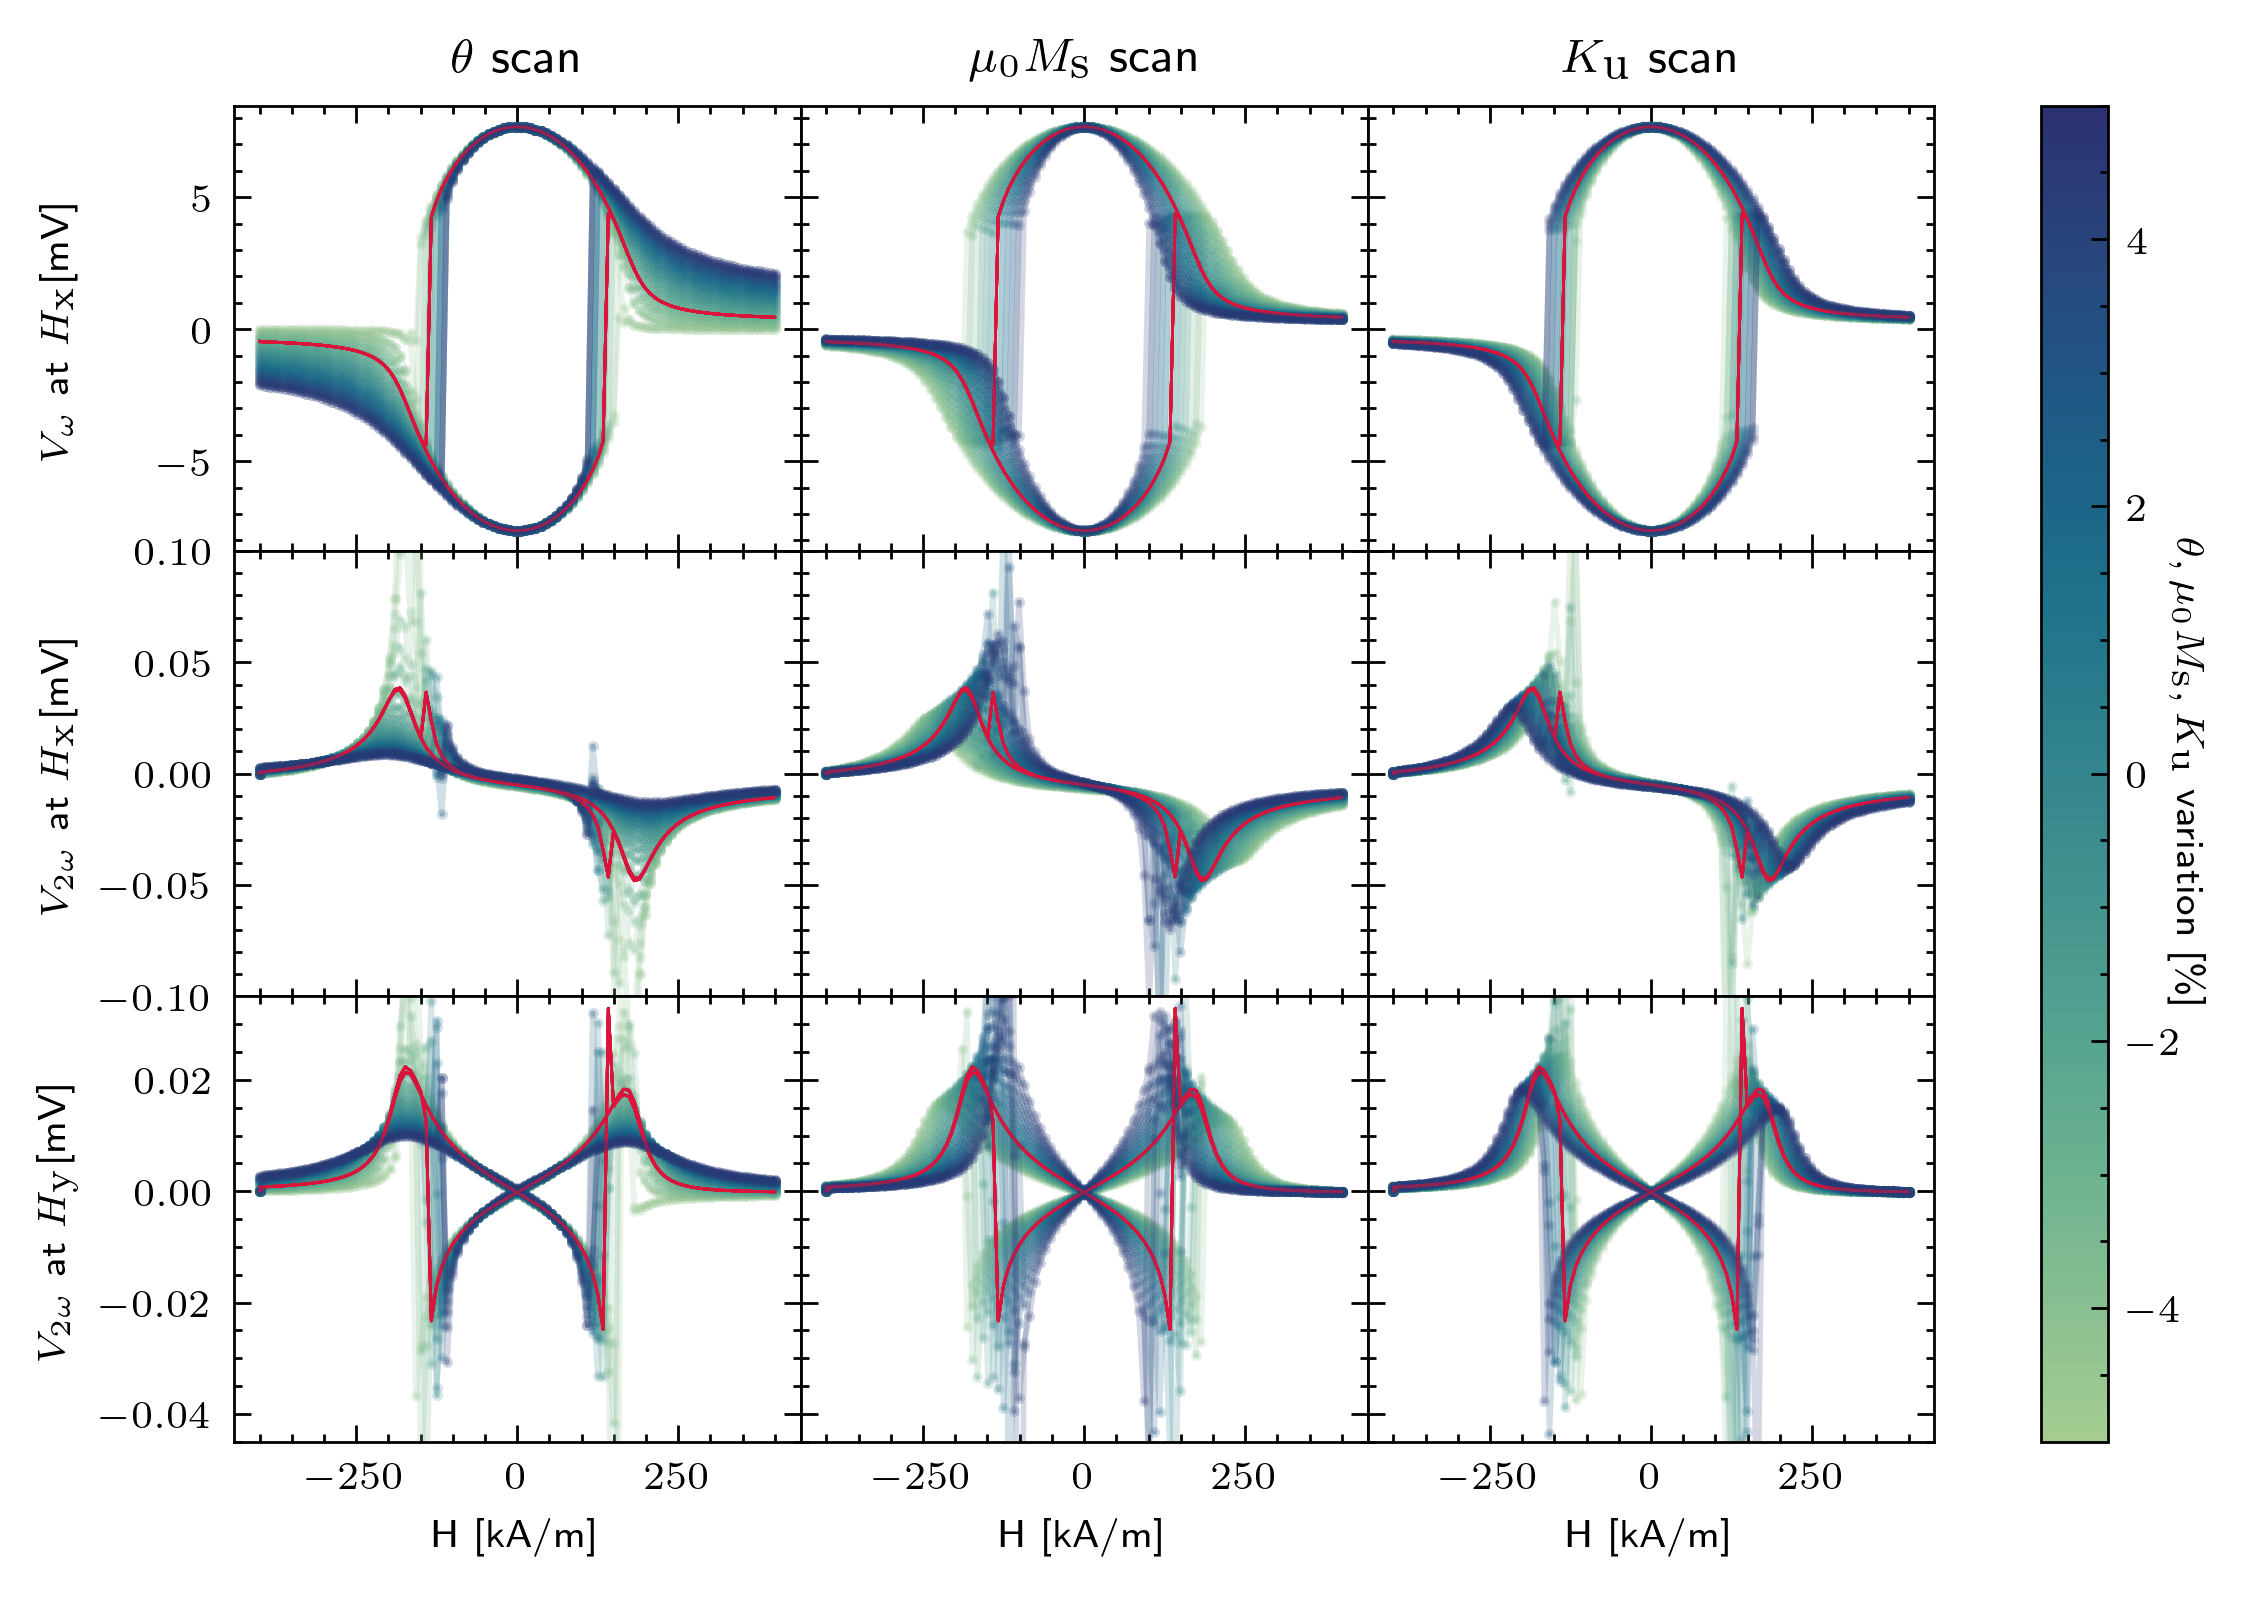

In [10]:
import seaborn as sns

ms = 1
lw = 1.5
mec = None
c = 'crimson'
with plt.style.context(['science', 'nature']):
    crest = sns.color_palette('crest', N)
    fig, ax = plt.subplots(3,
                           3,
                           figsize=(6, 4),
                           dpi=400,
                           sharey='row',
                           sharex='col')
    scale = 1e3
    galpha = 0.1
    for i, n in enumerate(['theta', 'Ms', 'Ku']):
        for k in range(N):
            if k == 0 or k == N - 1:
                galpha = 0.2
            else:
                galpha = 0.2

            lwm = 0.5
            galpham = 0.5
            hyscale = scale  # * 1e2
            ax[0][i].plot(ensemble_data[f"{n}_field_hx"][k],
                          ensemble_data[f"{n}_1f_hx"][k] * scale,
                          marker='o',
                          markersize=ms,
                          markeredgecolor=mec,
                          alpha=galpha,
                          color=crest[k])
            ax[1][i].plot(ensemble_data[f"{n}_field_hx"][k],
                          ensemble_data[f"{n}_2f_hx"][k] * scale,
                          marker='o',
                          markersize=ms,
                          markeredgecolor=mec,
                          alpha=galpha,
                          color=crest[k])
            ax[2][i].plot(ensemble_data[f"{n}_field_hy"][k],
                          ensemble_data[f"{n}_2f_hy"][k] * hyscale,
                          markersize=ms,
                          marker='o',
                          markeredgecolor=mec,
                          alpha=galpha,
                          color=crest[k])

            ax[0][i].plot(Hscan_Hx / 1e3,
                          amp_diag1f_Hx * scale,
                          linewidth=lwm,
                          alpha=galpham,
                          color=c)
            ax[1][i].plot(Hscan_Hx / 1e3,
                          phase_diag2f_Hx * scale,
                          linewidth=lwm,
                          alpha=galpham,
                          color=c)
            ax[2][i].plot(Hscan_Hy / 1e3,
                          phase_diag2f_Hy * hyscale,
                          linewidth=lwm,
                          alpha=galpham,
                          color=c)
            ax[1][i].set_ylim([-1.e-4 * scale, 1.e-4 * scale])
            ax[2][i].set_ylim([-4.5e-5 * hyscale, 3.5e-5 * hyscale])

    for i in range(3):
        ax[2][i].set_xlabel("H [kA/m]")

    ax[0][0].set_ylabel(r"$V_{\omega}$ at $H_\textrm{x}$[mV]")
    ax[1][0].set_ylabel(r"$V_{2\omega}$ at $H_\textrm{x}$[mV]")
    ax[2][0].set_ylabel(r"$V_{2\omega}$ at $H_\textrm{y}$[mV]")
    # names
    ax[0][0].set_title(r"$\theta$ scan")
    ax[0][1].set_title(r"$\mu_\mathrm{0}M_\textrm{s}$ scan")
    ax[0][2].set_title(r"$K_\textrm{u}$ scan")

    fig.align_ylabels()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0., hspace=0.)

    cmap = sns.color_palette("crest", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=-eps * 100, vmax=eps * 100)


    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=ax.ravel().tolist(),
                        orientation='vertical')
    cbar.ax.set_ylabel(r"$\theta, \mu_\mathrm{0}M_\textrm{s}, K_\textrm{u}$ variation [\%]",
                       rotation=270)


In [11]:
N = 30
eps = 0.2
Hdl_space = np.linspace((1 - eps) * Hdl, (1 + eps) * Hdl, N)
Hfl_space = np.linspace((1 - eps) * Hfl, (1 + eps) * Hfl, N)
theta = 92 # change here
torque_data = defaultdict(list)
for MODE in ('Hx', 'Hy'):
    mode = MODE.lower()
    for n, v in zip(['Hdl', 'Hfl'], [Hdl_space, Hfl_space]):
        for v_ in tqdm(v, desc=f'Computing: {n} for {MODE}'):
            if n == 'Hdl':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(
                    mode, theta=theta, Ms=Ms, Ku=Ku, Hdl=v_, Hfl=Hfl)
            elif n == 'Hfl':
                amp_diag1f, phase_diag2f, Hscan = compute_harmonics(
                    mode, theta=theta, Ms=Ms, Ku=Ku, Hdl=Hdl, Hfl=v_)
            else:
                raise ValueError("Unknown parameter")
            amp_diag1f -= amp_diag1f.mean()
            phase_diag2f -= phase_diag2f[0]
            torque_data[f"{n}_1f_{mode}"].append(amp_diag1f)
            torque_data[f"{n}_2f_{mode}"].append(phase_diag2f)
            torque_data[f"{n}_field_{mode}"].append(Hscan / 1e3)


Computing: Hfl for Hy: 100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


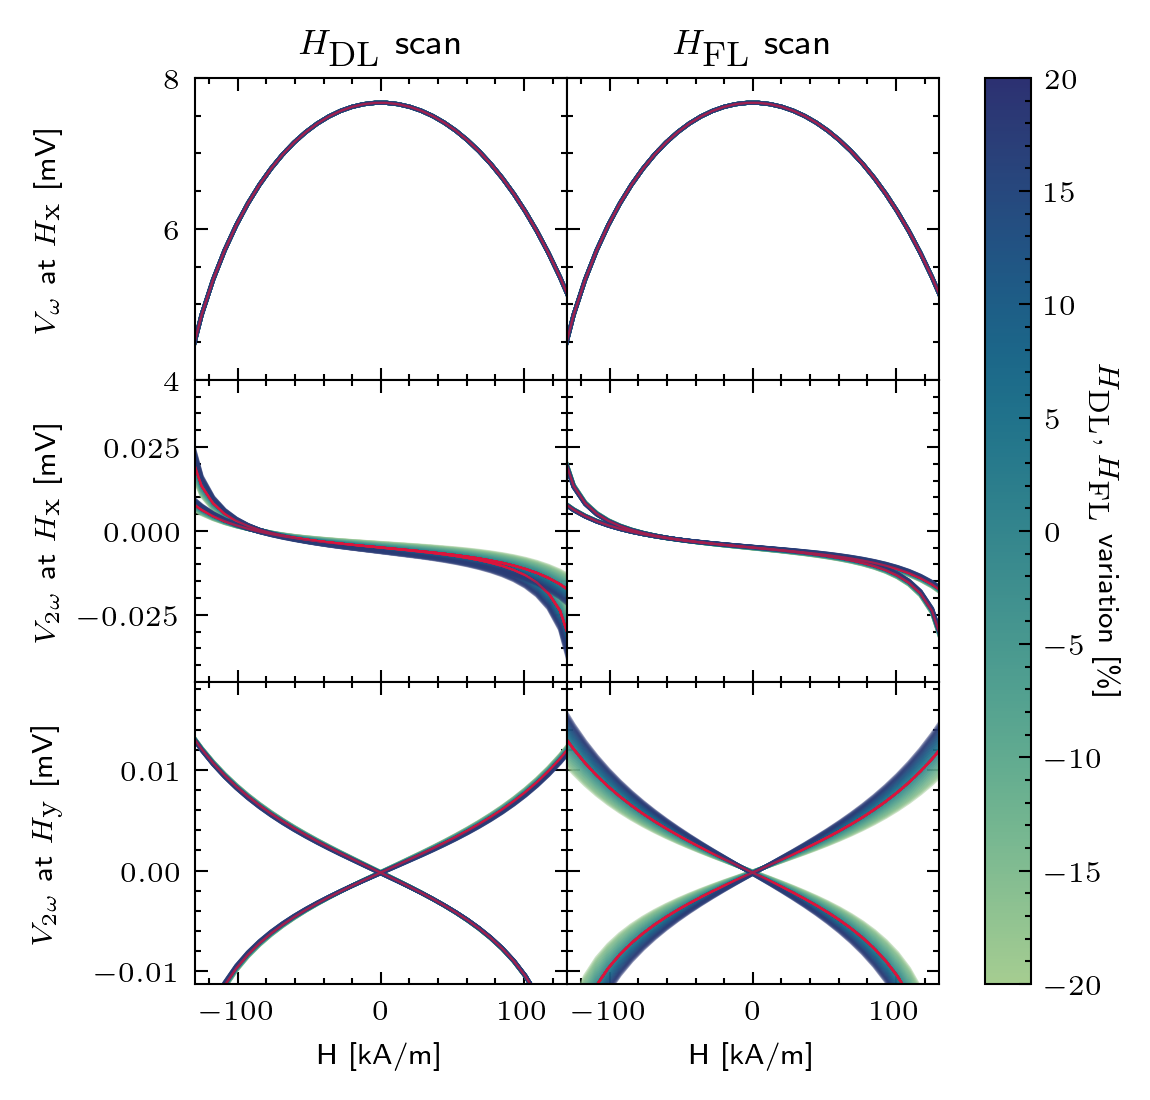

In [12]:
import seaborn as sns
ms = 1
lw = 1.5
mec = None
c = 'crimson'
with plt.style.context(['science', 'nature']):
    crest = sns.color_palette('crest', N)
    fig, ax = plt.subplots(3,
                           2,
                           figsize=(4, 4),
                           dpi=300,
                           sharey='row',
                           sharex='col')
    scale = 1e3
    galpha = 0.1
    for i, n in enumerate(['Hdl', 'Hfl']):
        for k in range(N):
            galpha = 0.5

            lwm = 0.5
            galpham = 0.5
            hyscale = scale  
            ax[0][i].plot(
                torque_data[f"{n}_field_hx"][k],
                torque_data[f"{n}_1f_hx"][k] * scale,
                alpha=galpha,
                color=crest[k])
            ax[1][i].plot(
                torque_data[f"{n}_field_hx"][k],
                torque_data[f"{n}_2f_hx"][k] * scale,
                alpha=galpha,
                color=crest[k])
            ax[2][i].plot(
                torque_data[f"{n}_field_hy"][k],
                torque_data[f"{n}_2f_hy"][k] * hyscale,

                alpha=galpha,
                color=crest[k])

            ax[0][i].plot(Hscan_Hx / 1e3,
                          amp_diag1f_Hx * scale,
                          linewidth=lwm,
                          alpha=galpham,
                          color=c)
            ax[1][i].plot(Hscan_Hx / 1e3,
                          phase_diag2f_Hx * scale,
                          linewidth=lwm,
                          alpha=galpham,
                          color=c)
            ax[2][i].plot(Hscan_Hy / 1e3,
                          phase_diag2f_Hy * hyscale,
                          linewidth=lwm,
                          alpha=galpham,
                          color=c)

            ax[1, i].set_ylim([-4.5e-4 * scale / 10, 4.5e-4 * scale / 10])
            ax[2, i].set_ylim([-4.5e-5 * scale / 4, 7.5e-5 * scale / 4])
            ax[0, i].set_ylim([4, 8])
            fx = 130
            ax[0, i].set_xlim([-fx, fx])

    for i in range(2):
        ax[2][i].set_xlabel("H [kA/m]")

    ax[0, 0].set_ylabel(r"$V_{\omega}$ at $H_\textrm{x}$ [mV]")
    ax[1, 0].set_ylabel(r"$V_{2\omega}$ at $H_\textrm{x}$ [mV]")
    ax[2, 0].set_ylabel(r"$V_{2\omega}$ at $H_\textrm{y}$ [mV]")

    ax[0, 0].set_title(r"$H_\textrm{DL}$ scan")
    ax[0, 1].set_title(r"$H_\textrm{FL}$ scan")
    cmap = sns.color_palette("crest", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=-eps * 100, vmax=eps * 100)
    fig.subplots_adjust(wspace=0., hspace=0.)
    fig.align_ylabels()
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=ax.ravel().tolist(),
                        orientation='vertical')
    cbar.ax.set_ylabel(r"$H_\textrm{DL}, H_\textrm{FL}$ variation [\%]",
                       rotation=270)